# MBIO 610 Final Modeling Project

Github page for data processing found [here](https://github.com/dbarnas/MBIO_610_Modeling_Project/tree/main/Data)

Project goal: Model the competition between stony coral and macroalgae+turf along a reef experiencing submarine groundwater discharge (SGD)

### Table of Contents
- [Model theory](#Model_theory)
- [2-species competition-only model showing stability over time](#two_sp_competition_only_timesteps)
- [3-species competition-only model showing stability over time](#three_sp_competition_only_timesteps)
- [2-species competition and sgd impact model (Coral and Macroalgae+Turf)](#two_sp_competition_sgd_impact_timesteps)
- [3-species competition and sgd impact model (Coral and Macroalgae+Turf)](#three_sp_competition_sgd_impact_timesteps)

Part 2: Analyze the system using a DIY numerical solver - 2 numerical integration methods
- [Calculate derivative $\delta N/ \delta t$](#calculate_derivative)
- [2-species model using 2nd order Runge-Kutta](#two_species_runge-kutta_2)
    - [2-species model output plots](#two_species_RK2_plots)
        - [2-species: Given initial population size](#two_species_given_init_pop_size)
        - [2-species: Randomize initial population size](#two_species_randomize_init_pop_size)
        - [2-species: Randomize SGD impact factor](#two_species_randomize_sgd_impact)
- [3-species model using 2nd order Runge-Kutta](#three_species_runge-kutta_2)
    - [3-species model output plots](#three_species_RK2_plots)
        - [3-species: Given initial population size](#three_species_given_init_pop_size)
        - [3-species: Randomize initial population size](#three_species_randomize_init_pop_size)
        - [3-species: Randomize SGD impact factor](#three_species_randomize_sgd_impact)


In [1]:
## IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

Initial assumptions for super simplicity for starters:
- No intraspecific competition (w/n coral or macroalgae+turf (for now)
- Interspecific competition (b/n coral and macroalgae+turf
- Macroalgae and turf are comparable enough to bring into single functional group (for now)
- Carrying capacity $K$ is 1.0 (or 100%) for both Coral and MA+T (denoted as M) groups in the absence of a second group
- MA+T intrinsic growth rate > Coral growth rate
- MA+T and Coral proportional cover shift over an SGD gradient and are covaried along reef ($R^2 = 0.69$, $p = 3e-11$)
- No mortality outside of competition and environmental impact factor (for now)

<a name = "Model_theory"></a>

### Follow a 2-species competition model with the inclusion of an environmental factor impacting species differently:
2-species competition model: ($K_i = 1-sp_j$)

$$\frac{\delta C}{\delta t} = \frac{r_C C}{K_C}(K_C - C - \alpha_{C,M} M)$$ 
(1)
$$\frac{\delta M}{\delta t} = \frac{r_M M}{K_M}(K_M - M - \alpha_{M,C} C)$$

2-species competition model including an environmental factor (n) impacting both species differently:

(where $n_i > 0$ has a negative impact on sp_i, and $n_i < 0$ has a positive impact on sp_i,
and $K_i = 1-sp_j-sp_k$)

$$\frac{\delta C}{\delta t} = \frac{r_C C}{K_C}(K_C - C - \alpha_{C,M} M - K_C n_C C)$$ 
(2)
$$\frac{\delta M}{\delta t} = \frac{r_M M}{K_M}(K_M - M - \alpha_{M,C} C - K_M n_M M)$$
$$r_C < r_M$$

3-species competition model including an environmental factor (n) impacting all species differently (although I could make the generalization that turf and MA may be impacted similarly...): 

$$\frac{\delta C}{\delta t} = \frac{r_C C}{K_C}(K_C - C - \alpha_{C,M} M - K_C n_C C)$$ 
(3)
$$\frac{\delta M}{\delta t} = \frac{r_M M}{K_M}(K_M - M - \alpha_{M,C} C - \alpha_{M,T} T - K_M n_M M)$$

$$\frac{\delta T}{\delta t} = \frac{r_T T}{K_T}(K_T - T - \alpha_{T,M} M - K_T n_T T)$$
$$r_C < r_M < r_T$$


<a name = "two_sp_competition_only_timesteps"></a>
### 2-species competition-only model showing stability over time

In [ ]:
# Mumby et al. 2007 example
# Define a function to calculate the derivative
def Mumby(t, N, r, a, mu, gamma, g):
    C,M = N
    return [r*C*(1-C-M) - a*C*M - mu*C, gamma*M*(1-C-M) + a*C*M - g*M/(1-C)]


In [380]:
# Based on my equations in (2)
def sgdcompetition_2(t, N, rC, rM, aC, aM, nC, nM):
    C,M = N
    return [(rC*C/(1-M))*((1-M)-C-aC*M-(1-M)*nC*C), (rM*M/(1-C))*((1-C)-M-aM*C-(1-C)*nM*M)]

In [364]:
# set parameters for testing
rC = 0.2 #coral growth
rM = 0.4 #algae growth

aC = 0.25 #algal impact onto coral
aM = 0.2 #coral impact onto algae

nC = 0 #1.5 #coral impact from sgd
nM = 0 #0.5 #algae impact from sgd

#K = 1.0 #max carrying capacity for coral and algae in the absence of second group
#K=1-sp2

time_steps = 80 #no. of time steps
start = 0 
stop = 80
time_points = np.linspace(start, stop, time_steps+1)

In [365]:
# Initial conditions
# In the mumby parameter space, you should observe bistability or alternative stable states
# Let's see what we get with my model
# The results of competition will depend on initial conditions

# at lowest phosphate and Nitrate+Nitrite levels, pops start at ~50% each
C0 = 0.5
M0 = 0.5

sol = solve_ivp(sgdcompetition_2, [start,stop], [C0,M0], method='RK45', args=(rC,rM, aC,aM, nC,nM), dense_output=True)
N = sol.sol(time_points)

### Plot Coral and Macroalgae+Turf trajectories over time (with no sgd impact factor)

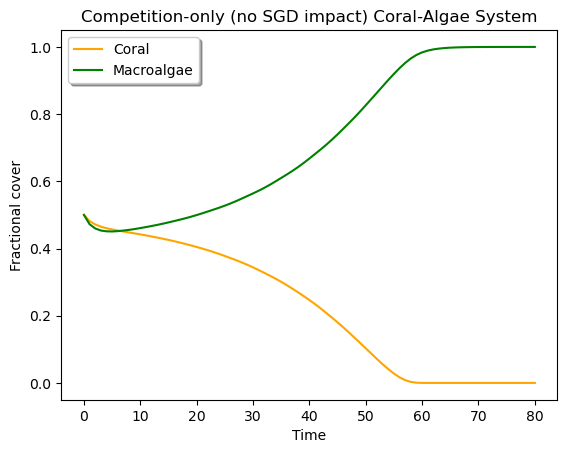

In [366]:
coral = N[0,:]
macroalgae = N[1,:]
plt.plot(time_points, coral, color='orange')
plt.plot(time_points, macroalgae, color='green')
plt.xlabel('Time')
plt.ylabel('Fractional cover')
plt.legend(['Coral', 'Macroalgae'], shadow=True)
plt.title('Competition-only (no SGD impact) Coral-Algae System')
plt.show()

<a name = "three_sp_competition_only_timesteps"></a>
### 3-species competition-only model showing stability over time

In [381]:
# Based on my equations in (3)
# def sgdcompetition(t, N, rC, rM, rT, aCM, aMC, aMT, aTM, K, nC, nM):
#     C,M,T = N
#     return [(rC*C/K)*(K-C-aCM*M-K*nC*C), # coral
#             (rM*M/K)*(K-M-aMC*C-aMT*T-K*nM*M), # macroalgae
#             (rT*T/K)*(K-T-aTM*M-K*nM*T)] # turf


# alternative to try dealing with max reef capacity issue:
def sgdcompetition_3(t, N, rC, rM, rT, aCM, aMC, aMT, aTM, nC, nM): # K = 1-sp2-sp3
    C,M,T = N
    return [(rC*C/(1-M-T))*((1-M-T)-C-aCM*M-(1-M-T)*nC*C), # coral
            (rM*M/(1-C-T))*((1-C-T)-M-aMC*C-aMT*T-(1-C-T)*nM*M), # macroalgae
            (rT*T/(1-C-M))*((1-C-M)-T-aTM*M-(1-C-M)*nM*T)] # turf

In [375]:
# set parameters for testing
rC = 0.2 #coral growth
rM = 0.4 #algae growth
rT = 0.45 #turf growth

aCM = 0.25 #algal impact onto coral
aMC = 0.2 #coral impact onto algae

aMT = 0.23 #turf impact on algae
aTM = 0.2 #algae impact on turf

nC = 0 #1.5 #coral impact from sgd
nM = 0 #0.5 #algae and turf impact from sgd

#K = 1.0 #max carrying capacity for coral and algae in the absence of second group
#K = 1-sp2-sp3

time_steps = 40 #no. of time steps (at 50+, runs on for too long)
start = 0 
stop = 40
time_points = np.linspace(start, stop, time_steps+1)

In [376]:
# Initial conditions
# In the mumby parameter space, you should observe bistability or alternative stable states
# Let's see what we get with my model
# The results of competition will depend on initial conditions

# at lowest phosphate and Nitrate+Nitrite levels, pops start at ~ the following:
C0 = 0.44
M0 = 0.4
T0 = 0.12

sol = solve_ivp(sgdcompetition_3, 
                [start,stop], 
                [C0,M0,T0], 
                method='RK45', 
                args=(rC,rM,rT, aCM,aMC, aMT,aTM, nC,nM), 
                dense_output=True)
N = sol.sol(time_points)

### Plot Coral, Macroalgae, and Turf trajectories over time (with no sgd impact factor)

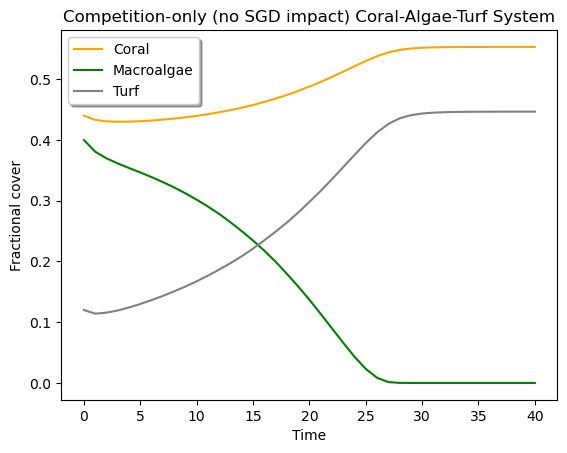

In [377]:
coral = N[0,:]
macroalgae = N[1,:]
turf = N[2,:]
plt.plot(time_points, coral, color='orange')
plt.plot(time_points, macroalgae, color='green')
plt.plot(time_points, turf, color = 'grey')
plt.xlabel('Time')
plt.ylabel('Fractional cover')
plt.legend(['Coral', 'Macroalgae', 'Turf'], shadow=True)
plt.title('Competition-only (no SGD impact) Coral-Algae-Turf System')
plt.show()

<a name = "two_sp_competition_sgd_impact_timesteps"></a>

### Plot Coral and Macroalgae+Turf trajectories over time (with constant sgd impact factor)

In [378]:
# set parameters for testing
rC = 0.2 #coral growth
rM = 0.4 #algae growth

aC = 0.2 #algal impact onto coral
aM = 0.2 #coral impact onto algae

nC = 1.5 #coral impact from sgd (dummy factors for phosphate impact)
nM = 0.5 #algae impact from sgd 

#K = 1.0 #max carrying capacity for coral and algae in the absence of second group
#K=1-sp2

time_steps = 100 #no. of time steps
start = 0 
stop = 100
time_points = np.linspace(start, stop, time_steps+1)

In [382]:
# Initial conditions
# at lowest phosphate and Nitrate+Nitrite levels, pops start at ~50% each
C0 = 0.5
M0 = 0.5

sol = solve_ivp(sgdcompetition_2, [start,stop], [C0,M0], method='RK45', args=(rC,rM, aC,aM, nC,nM), dense_output=True)
N = sol.sol(time_points)

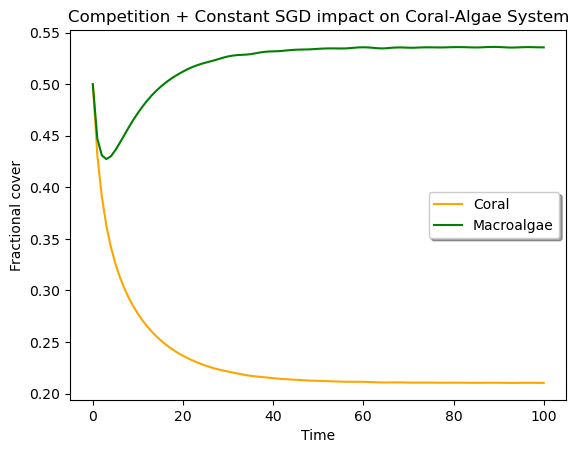

In [383]:
coral = N[0,:]
macroalgae = N[1,:]
plt.plot(time_points, coral, color='orange')
plt.plot(time_points, macroalgae, color='green')
plt.xlabel('Time')
plt.ylabel('Fractional cover')
plt.legend(['Coral', 'Macroalgae'], shadow=True)
plt.title('Competition + Constant SGD impact on Coral-Algae System')
plt.show()

<a name = "three_sp_competition_sgd_impact_timesteps"></a>

### Plot Coral, Macroalgae, and Turf trajectories over time (with constant sgd impact factor)

In [385]:
# set parameters for testing
rC = 0.2 #coral growth
rM = 0.4 #algae growth
rT = 0.45 #turf growth

aCM = 0.42# using r2 values from lm in R #0.3 #algal impact onto coral
aMC = 0.42# using r2 values from lm in R #0.2 #coral impact onto algae

aMT = 0.72# using r2 values from lm in R #0.23 #turf impact on algae
aTM = 0.72# using r2 values from lm in R #0.2 #algae impact on turf

nC = 1.5 #coral impact from sgd
nM = 0.5 #algae and turf impact from sgd

#K = 1.0 #max carrying capacity for coral and algae in the absence of second group
#K = 1-sp2-sp3

time_steps = 55 #no. of time steps
start = 0 
stop = 55
time_points = np.linspace(start, stop, time_steps+1)

In [386]:
# Initial conditions
# In the mumby parameter space, you should observe bistability or alternative stable states
# Let's see what we get with my model
# The results of competition will depend on initial conditions

# at lowest phosphate and Nitrate+Nitrite levels, pops start at ~ the following:
C0 = 0.44
M0 = 0.4
T0 = 0.12

sol = solve_ivp(sgdcompetition_3, 
                [start,stop], 
                [C0,M0,T0], 
                method='RK45', 
                args=(rC,rM,rT, aCM,aMC, aMT,aTM, nC,nM), 
                dense_output=True)
N = sol.sol(time_points)

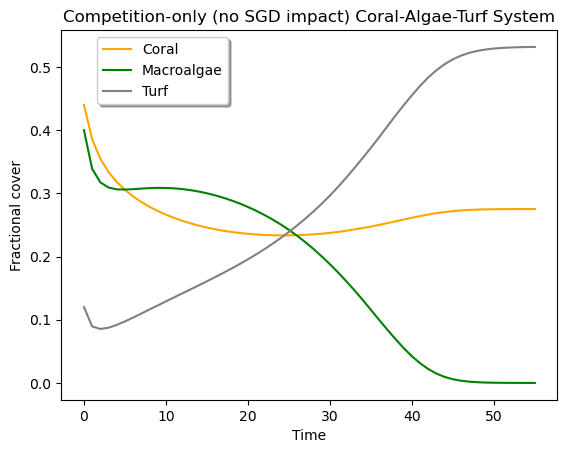

In [387]:
coral = N[0,:]
macroalgae = N[1,:]
turf = N[2,:]
plt.plot(time_points, coral, color='orange')
plt.plot(time_points, macroalgae, color='green')
plt.plot(time_points, turf, color = 'grey')
plt.xlabel('Time')
plt.ylabel('Fractional cover')
plt.legend(['Coral', 'Macroalgae', 'Turf'], shadow=True, bbox_to_anchor=(0.35,1))
plt.title('Competition-only (no SGD impact) Coral-Algae-Turf System')
plt.show()

## Part 2: Analyze the system using a DIY numerical solver - 2 numerical integration methods

<a name = "calculate_derivative"></a>
### Calculate derivative $\delta N / \delta t$

#### 2-species model

In [388]:
# My model:
def dNdt_2(C,M,P):
    
    dt = P['dt']
    
    # Calculate the derivative
    dC = (rC*C/(1-M))*((1-M)-C-aC*M-(1-M)*nC*C) * dt #Coral equation
    dM = (rM*M/(1-C))*((1-C)-M-aM*C-(1-C)*nM*M) * dt #Macroalgae equation
    
    return dC, dM

#### 3-species model

In [411]:
# My model:
def dNdt_3(C,M,T,P):
    
    dt = P['dt']
    
    # Calculate the derivative (using same equations as in sgdcompetition above)
    dC = (rC*C/(1-M-T))*((1-M-T)-C-aCM*M-(1-M-T)*nC*C) * dt #Coral equation
    dM = (rM*M/(1-C-T))*((1-C-T)-M-aMC*C-aMT*T-(1-C-T)*nM*M) * dt #Macroalgae equation
    dT = (rT*T/(1-C-M))*((1-C-M)-T-aTM*M-(1-C-M)*nM*T) * dt #Turf equation
    
    return dC, dM, dT

### Function to calculate the next value of C & M using the Euler method

Euler's method is based on taking successive linear approximations to the solution.

In [326]:
# # My model:
# # currently copying Mumby's example:
# def Euler(C,M,P): #Euler
    
#     C_init = C
#     M_init = M
    
#     dC, dM = dNdt(C,M,P)
    
#     C = C + dC
#     M = M + dM
    
#     return C, M

<a name = "two_species_runge-kutta_2"></a>

### Function to calculate the next value of C & M using the 2nd order Runge-Kutta method

In [412]:
# My model:
# currently copying Mumby's example:
def RK2_2(C,M,P): #2nd-order Runge-Kutta
    
    C_init = C
    M_init = M
    
    dC1, dM1 = dNdt_2(C,M,P)
    
    C1 = C + 0.5*dC1 # what is the 0.5 value from??
    M1 = M + 0.5*dM1
    
    dC2, dM2 = dNdt_2(C1,M1,P)
    
    dCave = (dC1 + dC2)/2
    dMave = (dM1 + dM2)/2
    
    C = C_init + dCave
    M = M_init + dMave
    
    return C, M


def run_model_RK2_2(INIT_C,INIT_M,P):
   
    NUMSTEPS = P['NUMSTEPS']
    
    C = np.zeros((NUMSTEPS))
    M = np.zeros((NUMSTEPS))
    
    C[0] = INIT_C
    M[0] = INIT_M
    
    for step in np.arange(0,NUMSTEPS-1):
        C[step+1],M[step+1] = RK2_2(C[step],M[step],P)
    
    return C, M

In [413]:
# My model:
# Set parameter values for testing (using constant sgd impact factor)
rC = 0.2 #coral growth
rM = 0.4 #algae growth

aC = 0.2 #0.87 if using r2 values from lm in R #algal impact onto coral
aM = 0.2 #0.87 if using r2 values from lm in R #coral impact onto algae

nC = 1.5 #coral impact from sgd (dummy factors for phosphate impact)
nM = 0.5 #algae impact from sgd 

#K = 1.0 #max carrying capacity for coral and algae in the absence of second group
#K = 1-sp1

dt = 0.1 #step size
NUMYEARS = 100
NUMSTEPS = int(NUMYEARS/dt)


# Create a dictionary object called 'parameters_dict'
parameters_dict = {'dt':dt,
                    'NUMSTEPS': NUMSTEPS, 
                    'rC': rC, 
                    'rM': rM,
                    'aC': aC,
                    'aM': aM,
                    'nC': nC,
                    'nM': nM
                    }

# set initial conditions for C0 and M0
C0 = 0.5
M0 = 0.5

# Generate output
C_array1, M_array1 = run_model_RK2_2(C0,M0,parameters_dict)

<a name = "two_species_RK2_plots"></a>
### Plot 2-species model output (RK2)

<a name = "two_species_given_init_pop_size"></a>
2-species Plot: Given Initial Population Size

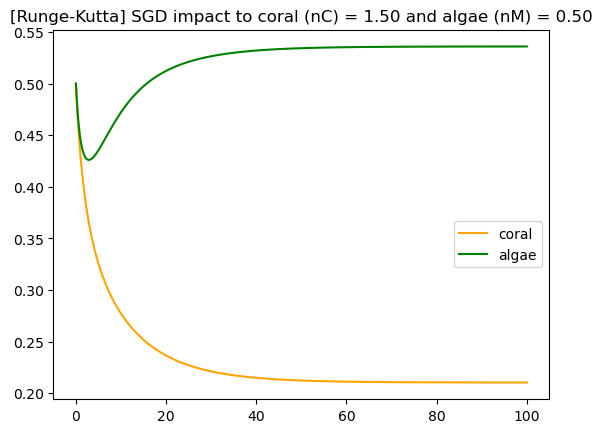

In [414]:
# Plot the results using the second order Runge-Kutta
# copying code from Mumby example:
x_vals = np.linspace(0,NUMYEARS,NUMSTEPS)
plt.plot(x_vals, C_array1, c='orange')
plt.plot(x_vals, M_array1, c='green')
plt.legend(['coral', 'algae'], bbox_to_anchor=(1,0.5))
plt.title('[Runge-Kutta] SGD impact to coral (nC) = '+ 
          '{0:.2f}'.format(nC) + # two decimal places only for string
          ' and algae (nM) = ' + 
          '{0:.2f}'.format(nM));

<a name = "two_species_randomize_init_pop_size"></a>
2-species Plot: Randomize Initial Population Size

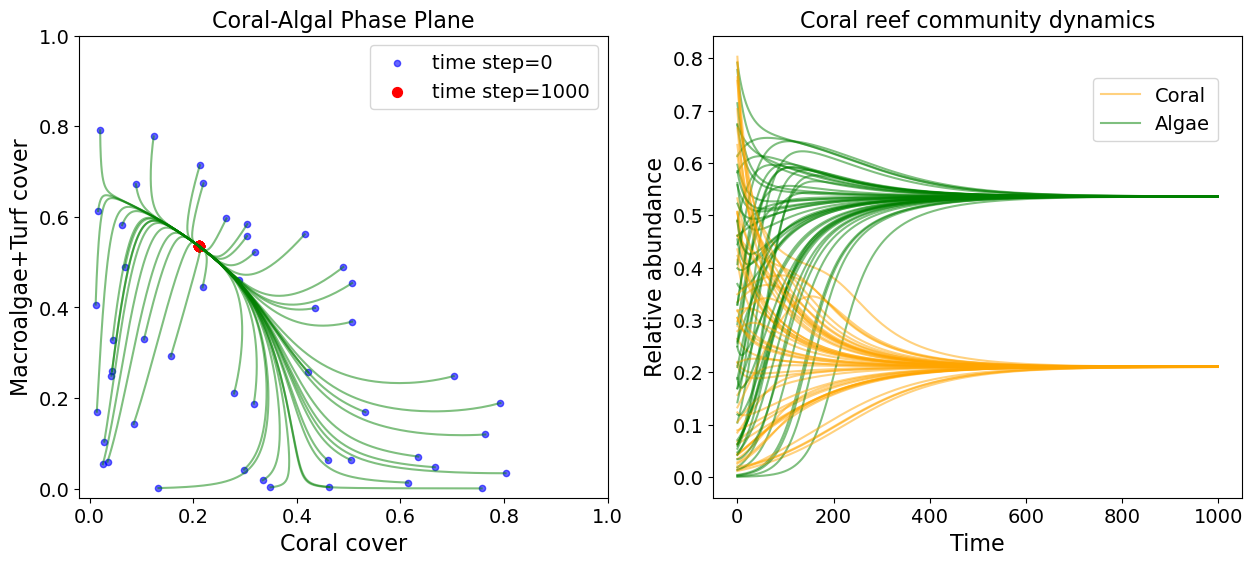

In [415]:
# for loop to create random INITIAL POPULATION SIZES for both C and M (0 < N < 1)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

for i in np.arange(0,100):
    C0 = np.random.random()
    M0 = np.random.random()
    # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
    if (C0 + M0 <= 1) : 
        C_array, M_array = run_model_RK2_2(C0,M0,parameters_dict)
        if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
            color = 'orange'
        else:
            color='green'
        ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
        item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
        item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
        ax2.plot(C_array, c='orange', alpha=0.5) # plot the coral time series in plot B
        ax2.plot(M_array, c='green', alpha=0.5) # plot the macroalgae time series in plot B

ax1.legend([item1, item2], ['time step=0', 'time step=1000'], fontsize=14)
ax1.set_xlabel("Coral cover", fontsize=16);
ax1.set_ylabel("Macroalgae+Turf cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane', fontsize=16)
ax1.set_xlim([-0.02,1])
ax1.set_ylim([-0.02,1])

ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(0.70, 0.75), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16);


<a name = "two_species_randomize_sgd_impact"></a>
#### Next, use the above for loop with an adaptation for changing the sgd parameter value

2-species Plot: Randomize SGD Impact Factor

In [416]:
# My model:
# Set parameter values for testing
rC = 0.2 #coral growth
rM = 0.4 #algae growth

aC = 0.2 #algal impact onto coral
aM = 0.2 #coral impact onto algae

nC = 1.5 #coral impact from sgd (dummy factors for phosphate impact)
nM = 0.5 #algae impact from sgd 

K = 1.0 #max carrying capacity for coral and algae in the absence of second group

dt = 0.1 #step size
NUMYEARS = 100
NUMSTEPS = int(NUMYEARS/dt)


# Create a dictionary object called 'parameters_dict'
parameters_dict = {'dt':dt,
                    'NUMSTEPS': NUMSTEPS, 
                    'rC': rC, 
                    'rM': rM,
                    'aC': aC,
                    'aM': aM,
                    'nC': nC,
                    'nM': nM
                    }

# set initial conditions for C0 and M0
C0 = 0.5
M0 = 0.5

# Generate output
#C_array0, M_array0 = run_model_Euler(C0,M0,parameters_dict)
C_array1, M_array1 = run_model_RK2_2(C0,M0,parameters_dict) # will use RK2 for the for loop below

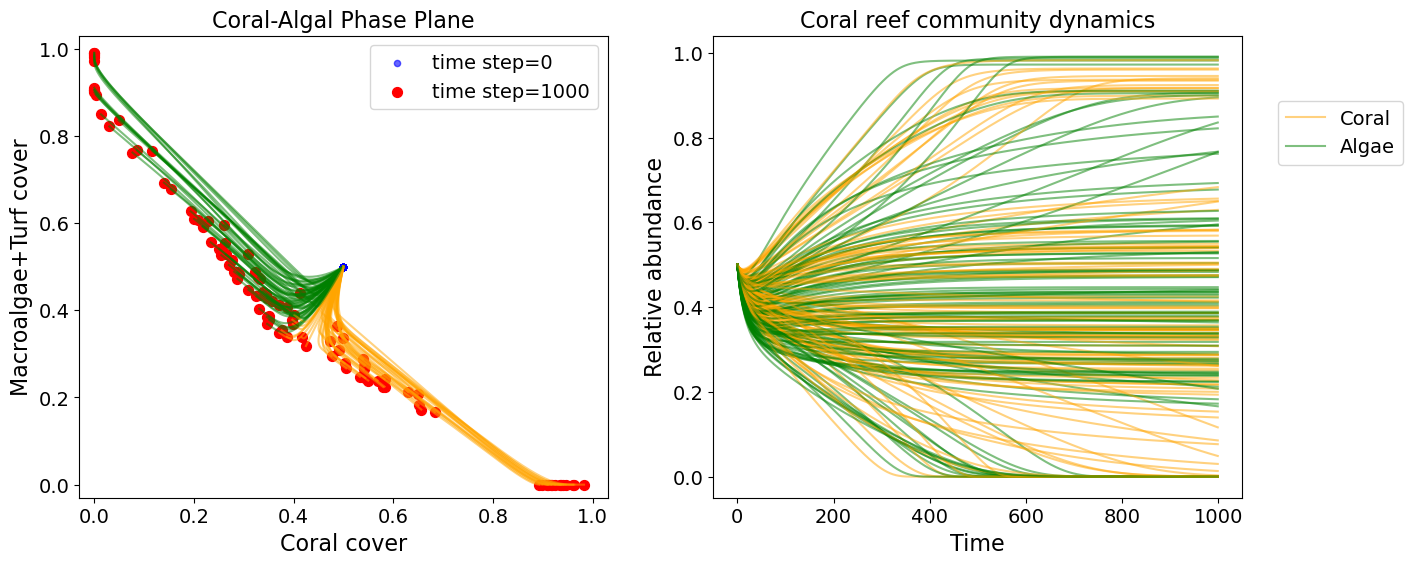

In [417]:
# for loop to create random SGD impact factors
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

for i in np.arange(0,100):
    nC = np.random.random()
    nM = np.random.random()
    # only use initial conditions that make sense, though not yet sure what bounds to use on n
    #if (nC <= 1 & nM <= 1) :  # ignoring bounds for now
    C_array, M_array = run_model_RK2_2(C0,M0,parameters_dict)
    if (C_array[-1] > M_array[-1]): # if final coral value > final macroalgae value
        color = 'orange'
    else:
        color='green'
    ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
    item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
    item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
    ax2.plot(C_array, c='orange', alpha=0.5) # plot the coral time series in plot B
    ax2.plot(M_array, c='green', alpha=0.5) # plot the macroalgae time series in plot B
    #ax3.plot(nC, c='orange', alpha = 0.5) # plot the coral time series in plot C
    #ax4.plot(nM, c='green', alpha = 0.5) # plot the macroalgae time series in plot C


ax1.legend([item1, item2], ['time step=0', 'time step=1000'], fontsize=14)
ax1.set_xlabel("Coral cover", fontsize=16);
ax1.set_ylabel("Macroalgae+Turf cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane', fontsize=16)
ax1.set_xlim([-0.03,1.03])
ax1.set_ylim([-0.03,1.03])


ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16);


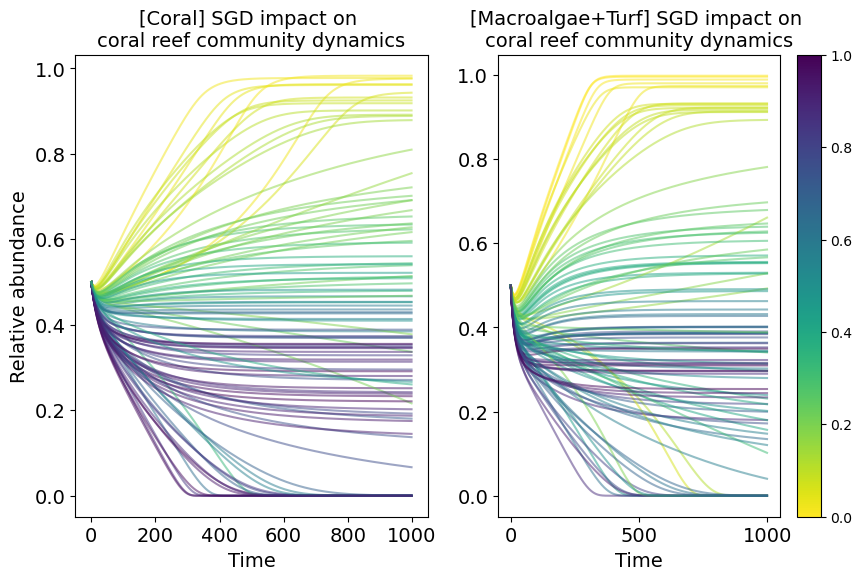

In [418]:
# for loop to create random SGD impact factors
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,6))

# set color map
cmap = plt.get_cmap().reversed() # reversed() shows yellow as low numbers and dark colors as high numbrs

# create empty lists to store sgd impact values in for loop
#nC_array = []
#nM_array = []

for i in np.arange(0,100):
    # randomize the sgd parameter, while holding starting population size constant
    nC = (np.random.random()) # populates values b/n 0 and 1 - may need to revisit to get larger or neg values
    nM = (np.random.random())
    
    # store random values in lists for sgd parameter impact factors
    #nC_array.append(nC)
    #nM_array.append(nM)
    
    C_array, M_array = run_model_RK2_2(C0,M0,parameters_dict)
    
    ax1.plot(C_array, c=cmap(nC), alpha = 0.5) # plot the coral time series in plot C
    ax2.plot(M_array, c=cmap(nM), alpha = 0.5) # plot the macroalgae time series in plot D
    

#ax1.legend(['SGD impact \nfactor range'], loc='lower left', bbox_to_anchor=(-0.75, 0.8), fontsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Time", fontsize=14);
ax1.set_ylabel("Relative abundance", fontsize=14);
ax1.set_title('[Coral] SGD impact on \ncoral reef community dynamics', fontsize=14);



fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax2)
#ax2.legend(['SGD impact \nfactor range'], loc='lower left', bbox_to_anchor=(1.05, 0.8), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=14);
#ax2.set_ylabel("Relative abundance", fontsize=14);
ax2.set_title('[Macroalgae+Turf] SGD impact on \ncoral reef community dynamics', fontsize=14);

## ISSUE WITH THIS PLOT: doesn't species relative to each other, but maybe that's okay.

<a name = "three_species_runge-kutta_2"></a>

### Function to calculate the next value of C, M, & T using the 2nd order Runge-Kutta method

In [421]:
# My model:
# currently copying Mumby's example:
def RK2_3(C,M,T,P): #2nd-order Runge-Kutta
    
    C_init = C
    M_init = M
    T_init = T
    
    dC1, dM1, dT1 = dNdt_3(C,M,T,P)
    
    C1 = C + 0.5*dC1 # what is the 0.5 value from??
    M1 = M + 0.5*dM1
    T1 = T + 0.5*dT1
    
    dC2, dM2, dT2 = dNdt_3(C1,M1,T1,P)
    
    dCave = (dC1 + dC2)/2
    dMave = (dM1 + dM2)/2
    dTave = (dT1 + dT2)/2
    
    C = C_init + dCave
    M = M_init + dMave
    T = T_init + dTave
    
    return C, M, T


def run_model_RK2_3(INIT_C,INIT_M,INIT_T,P):
   
    NUMSTEPS = P['NUMSTEPS']
    
    C = np.zeros((NUMSTEPS))
    M = np.zeros((NUMSTEPS))
    T = np.zeros((NUMSTEPS))
    
    C[0] = INIT_C
    M[0] = INIT_M
    T[0] = INIT_T
    
    for step in np.arange(0,NUMSTEPS-1):
        C[step+1],M[step+1],T[step+1] = RK2_3(C[step],M[step],T[step],P)
    
    return C, M, T

In [448]:
# My model:
# Set parameter values for testing (using constant sgd impact factor)
rC = 0.2 #coral growth
rM = 0.4 #algae growth
rT = 0.45 #turf growth

aCM = 0.42# using r2 values from lm in R #0.3 #algal impact onto coral
aMC = 0.42# using r2 values from lm in R #0.2 #coral impact onto algae

aMT = 0.72# using r2 values from lm in R #0.23 #turf impact on algae
aTM = 0.72# using r2 values from lm in R #0.2 #algae impact on turf

nC = 1.5 #coral impact from sgd
nM = 0.5 #algae and turf impact from sgd

#K = 1.0 #max carrying capacity for coral and algae in the absence of second group
#K = 1-sp2-sp3

dt = 0.05 #step size
NUMYEARS = 100
NUMSTEPS = int(NUMYEARS/dt)


# Create a dictionary object called 'parameters_dict'
parameters_dict = {'dt':dt,
                    'NUMSTEPS': NUMSTEPS, 
                    'rC': rC, 
                    'rM': rM,
                    'rT': rT,
                    'aCM': aCM,
                    'aMC': aMC,
                    'aMT': aMT,
                    'aTM': aTM,
                    'nC': nC,
                    'nM': nM
                    }

# set initial conditions for C0, M0, and T0
# at lowest phosphate and Nitrate+Nitrite levels, pops start at ~ the following:
C0 = 0.44
M0 = 0.4
T0 = 0.12

# Generate output
C_array1, M_array1, T_array1 = run_model_RK2_3(C0,M0,T0,parameters_dict)

<a name = "three_species_RK2_plots"></a>
### Plot 3-species model output (RK2)

<a name = "three_species_given_init_pop_size"></a>
3-species Plot: Given Initial Population Size

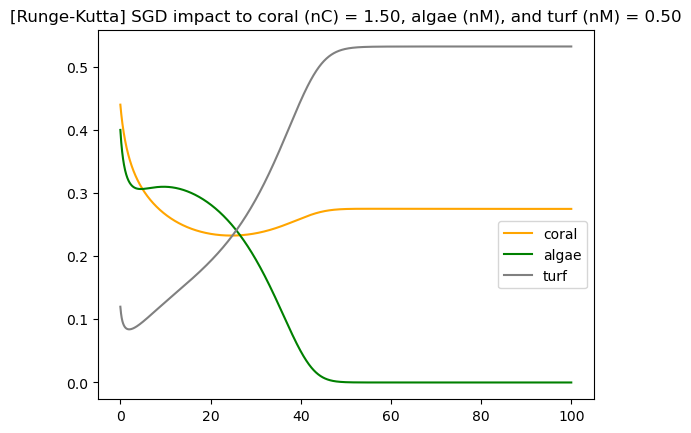

In [449]:
# Plot the results using the second order Runge-Kutta
# copying code from Mumby example:
x_vals = np.linspace(0,NUMYEARS,NUMSTEPS)
plt.plot(x_vals, C_array1, c='orange')
plt.plot(x_vals, M_array1, c='green')
plt.plot(x_vals, T_array1, c='grey')
plt.legend(['coral', 'algae', 'turf'], bbox_to_anchor=(1,0.5))
plt.title('[Runge-Kutta] SGD impact to coral (nC) = '+ 
          '{0:.2f}'.format(nC) + # two decimal places only for string
          ', algae (nM), and turf (nM) = ' + 
          '{0:.2f}'.format(nM));

<a name = "three_species_randomize_init_pop_size"></a>
3-species Plot: Randomize Initial Population Size

In [ ]:
# Coral vs Macroalgae

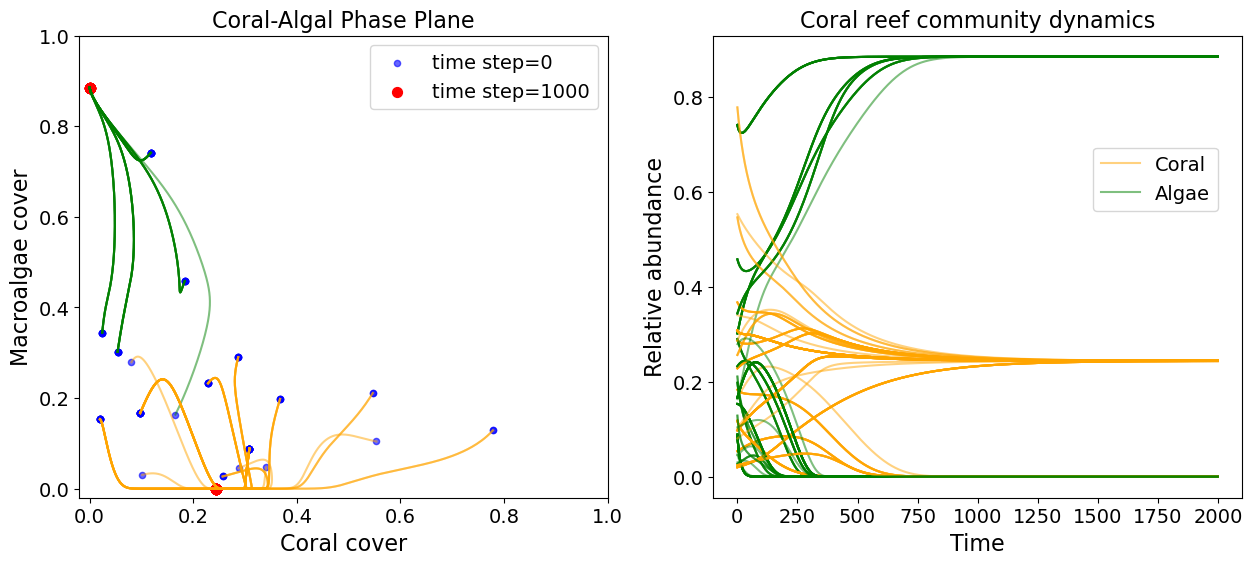

In [485]:
# for loop to create random INITIAL POPULATION SIZES for both C and M (0 < N < 1)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

for i in np.arange(0,100):
    C0 = np.random.random()
    M0 = np.random.random()
    T0 = np.random.random()
    # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
    
    if (C0 + M0 + T0 <= 1) : 
        C_array, M_array, T_array = run_model_RK2_3(C0,M0,T0,parameters_dict)
    
        if (C_array[-1] > M_array[-1]): # if final coral value > final MA value & C > turf final value
            color = 'orange'
        elif (M_array[-1] > C_array[-1]):
            color='green'
        else:
            color = 'black'

    ### NEED TO SORT OUT BEST WAY TO PLOT 2 SPECIES FROM A 3 SPECIES MODEL
#         if (C_array[-1] > M_array[-1] and
#             C_array[-1] > T_array[-1]): # if final coral value > final MA value & C > turf final value
#             color = 'orange'
#         elif (M_array[-1] > C_array[-1] and
#               M_array[-1] > T_array[-1]):
#             color='green'
#         else:
#             color = "grey"
    ax1.plot(C_array, M_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
    item1 = ax1.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
    item2 = ax1.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red
    ax2.plot(C_array, c='orange', alpha=0.5) # plot the coral time series in plot B
    ax2.plot(M_array, c='green', alpha=0.5) # plot the macroalgae time series in plot B


ax1.legend([item1, item2], ['time step=0', 'time step=1000'], fontsize=14)
ax1.set_xlabel("Coral cover", fontsize=16);
ax1.set_ylabel("Macroalgae cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane', fontsize=16)
ax1.set_xlim([-0.02,1])
ax1.set_ylim([-0.02,1])

ax2.legend(['Coral', 'Algae'], loc='lower left', bbox_to_anchor=(0.70, 0.6), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16);


In [ ]:
# Macroalgae vs Turf

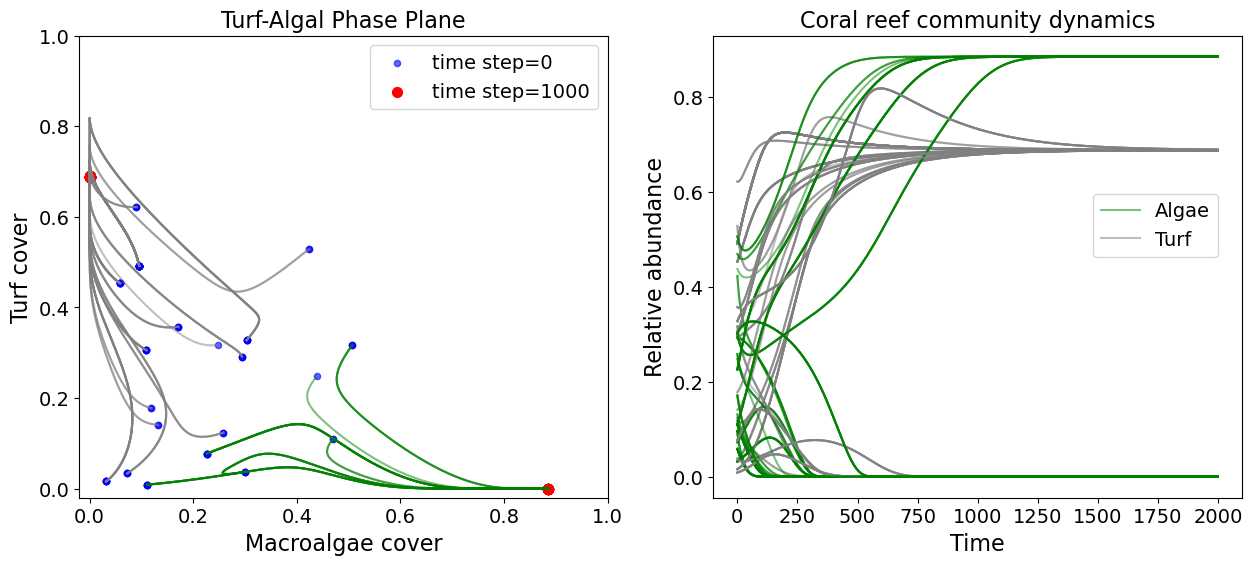

In [486]:
# for loop to create random INITIAL POPULATION SIZES for both C and M (0 < N < 1)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

for i in np.arange(0,100):
    C0 = np.random.random()
    M0 = np.random.random()
    T0 = np.random.random()
    # only use initial conditions that make sense, i.e. Initial Coral + Macroalgae must be less than 1
    if (C0 + M0 + T0 <= 1) : 
        C_array, M_array, T_array = run_model_RK2_3(C0,M0,T0,parameters_dict)
    if (M_array[-1] > T_array[-1]): # M > T
        color = 'green'
    elif (T_array[-1] > M_array[-1]): # T > M
        color='grey'
    else:
        color = "black"
    ax1.plot(M_array, T_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
    item1 = ax1.scatter(M_array[0], T_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
    item2 = ax1.scatter(M_array[-1], T_array[-1], color='red', s=50) # plot the final point in red
    ax2.plot(M_array, c='green', alpha=0.5) # plot the coral time series in plot B
    ax2.plot(T_array, c='grey', alpha=0.5) # plot the macroalgae time series in plot B

ax1.legend([item1, item2], ['time step=0', 'time step=1000'], fontsize=14)
ax1.set_xlabel("Macroalgae cover", fontsize=16);
ax1.set_ylabel("Turf cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Turf-Algal Phase Plane', fontsize=16)
ax1.set_xlim([-0.02,1])
ax1.set_ylim([-0.02,1])

ax2.legend(['Algae', 'Turf'], loc='lower left', bbox_to_anchor=(0.70, 0.5), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16);


<a name = "three_species_randomize_sgd_impact"></a>
#### Next, use the above for loop with an adaptation for changing the sgd parameter value

3-species Plot: Randomize SGD Impact Factor

In [489]:
# Coral vs Macroalgae 

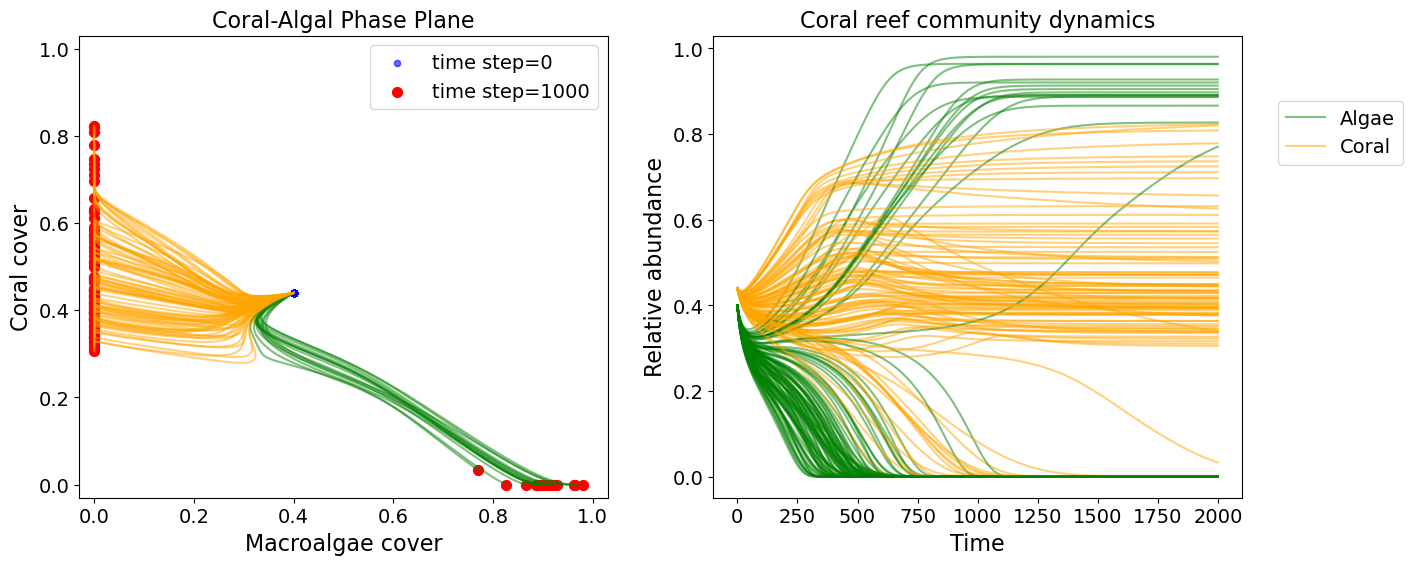

In [487]:
# for loop to create random SGD IMPACT FACTORS
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

C0 = 0.44
M0 = 0.4
T0 = 0.12

for i in np.arange(0,100):
    nC = np.random.random()
    nM = np.random.random()
    # only use initial conditions that make sense, though not yet sure what bounds to use on n
    
    C_array, M_array, T_array = run_model_RK2_3(C0,M0,T0,parameters_dict)
    
    if (C_array[-1] > M_array[-1]):
        color = 'orange'
    elif (M_array[-1] > C_array[-1]):
        color = 'green'
    else:
        color = 'black'
    
#     if (C_array[-1] > M_array[-1] and
#         C_array[-1] > T_array[-1]): # if final coral value > final macroalgae value
#         color = 'orange'
#     elif (M_array[-1] > C_array[-1] and
#           M_array[-1] > T_array[-1]):
#         color='green'
#     else:
#         color = 'grey'
    ax1.plot(M_array, C_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
    item1 = ax1.scatter(M_array[0], C_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
    item2 = ax1.scatter(M_array[-1], C_array[-1], color='red', s=50) # plot the final point in red
    ax2.plot(M_array, c='green', alpha=0.5) # plot the coral time series in plot B
    ax2.plot(C_array, c='orange', alpha=0.5) # plot the macroalgae time series in plot B
    


ax1.legend([item1, item2], ['time step=0', 'time step=1000'], fontsize=14)
ax1.set_xlabel("Macroalgae cover", fontsize=16);
ax1.set_ylabel("Coral cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Coral-Algal Phase Plane', fontsize=16)
ax1.set_xlim([-0.03,1.03])
ax1.set_ylim([-0.03,1.03])


ax2.legend(['Algae', 'Coral'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16);


In [ ]:
# Macroalgae vs Turf

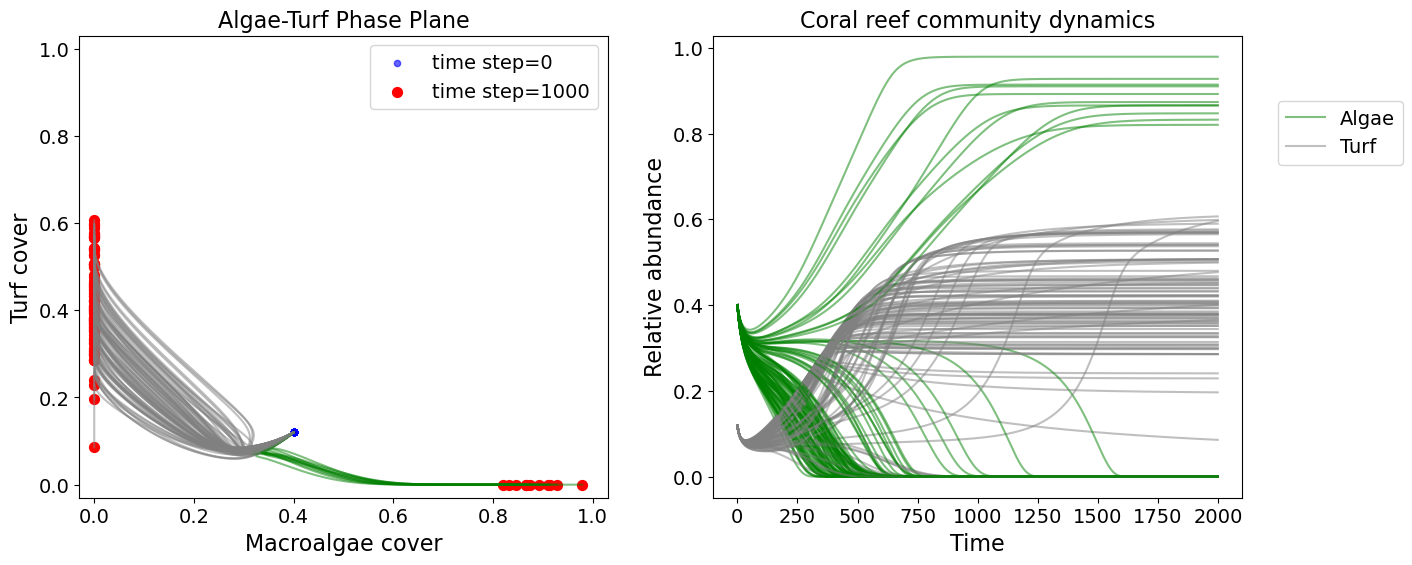

In [488]:
# for loop to create random SGD IMPACT FACTORS
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

C0 = 0.44
M0 = 0.4
T0 = 0.12

for i in np.arange(0,100):
    nC = np.random.random()
    nM = np.random.random()
    # only use initial conditions that make sense, though not yet sure what bounds to use on n
    
    C_array, M_array, T_array = run_model_RK2_3(C0,M0,T0,parameters_dict)

    if (M_array[-1] > T_array[-1]):
        color = 'green'
    elif (T_array[-1] > M_array[-1]):
        color = 'grey'
    else:
        color = 'black'    
#     if (M_array[-1] > T_array[-1] and
#         M_array[-1] > C_array[-1]): # if final coral value > final macroalgae value
#         color = 'green'
#     elif (T_array[-1] > M_array[-1] and
#           T_array[-1] > C_array[-1]):
#         color='grey'
#     else:
#         color = 'orange'
    
    ax1.plot(M_array, T_array, color=color, alpha=0.5) # plot the trajectory in the phase plane (plot A)
    item1 = ax1.scatter(M_array[0], T_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
    item2 = ax1.scatter(M_array[-1], T_array[-1], color='red', s=50) # plot the final point in red
    ax2.plot(M_array, c='green', alpha=0.5) # plot the coral time series in plot B
    ax2.plot(T_array, c='grey', alpha=0.5) # plot the macroalgae time series in plot B
    

ax1.legend([item1, item2], ['time step=0', 'time step=1000'], fontsize=14)
ax1.set_xlabel("Macroalgae cover", fontsize=16);
ax1.set_ylabel("Turf cover", fontsize=16);
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Algae-Turf Phase Plane', fontsize=16)
ax1.set_xlim([-0.03,1.03])
ax1.set_ylim([-0.03,1.03])


ax2.legend(['Algae', 'Turf'], loc='lower left', bbox_to_anchor=(1.05, 0.7), fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Time", fontsize=16);
ax2.set_ylabel("Relative abundance", fontsize=16);
ax2.set_title('Coral reef community dynamics', fontsize=16);
